In [267]:
import pandas as pd
import numpy as np
import os

# Reading flights Data and Adding Delayed Column

'delayed' column is added according to the logic given, i.,e a flight will be delayed if its arrival delay is 15 or more than 15 minutes.
<br>Will try to predict this variable using the exsiting data.
<br>To evaluate the model accuracy, will convert the data into 'train' and 'test' adding 'delayed' as stratified column

In [268]:


flights_df = pd.read_csv('Flight_on_time_HIX.csv')
weather_df = pd.read_csv('weather.csv')
flights_df['delayed'] = flights_df['Arrival_Delay_Minutes'].apply(lambda x : 1 if x>=15 else 0)

from sklearn.model_selection import train_test_split
train, test = train_test_split(flights_df, test_size=0.2, stratify=flights_df['delayed'], random_state=0, shuffle=1000)

train_y = train['delayed']
train_x = train.drop('delayed', axis=1)
test_y = test['delayed']
test_x = test.drop('delayed', axis=1)

# Feature Engineering and Data Processing

Following Features are added:
1. 'Journey time': Actual journey time(minutes) if flight departs at scheduled time.
2. 'Left Journey time': Journey time according(minutes) to the Actual departure time of flight.
3. 'Airline', 'Plane_ID', 'Origin_Airport', 'Destination_Airport': converted into one hot encoding
4. 'Flight_Distance', 'Departure_Delay_Minutes', 'journey_time', 'left_journey_time' : These columns are converted into Numeric and then standardized.

Not taking any varaibles of Arrival other than Scheduled Arrival time, because this would be present with us for future data as well.

In [269]:
from sklearn.preprocessing import OneHotEncoder
import datetime
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


def to_datetime(val):
    try:
        if len(val) < 4:
            if len(val)==1:
                val =  datetime.time(hour=int(val[0]))
            else:
                val =  datetime.time(hour=int(val[0]), minute=int(val[1:]))
        else:
            if int(val[0:2]) == 24:
                hour = '00'
            else:
                hour = val[0:2]
            val =  datetime.time(hour=int(hour), minute=int(val[2:4]))
        return datetime.datetime.combine(datetime.date.today(), val)
    except Exception as e:
        print(e)
        print(val)
    
def preprocess(dataset, train_flag=True):
    data = deepcopy(dataset)
    date_time_cols = ['Scheduled_Departure_Time','Actual_Departure_Time', 'Departure_WheelsOff', 'Scheduled_Arrival_Time']
    for col in date_time_cols:
        data[col] = data[col].apply(lambda x: to_datetime(str(int(x))))
    
    data['journey_time'] = data.apply(lambda x: (x['Scheduled_Arrival_Time']-x['Scheduled_Departure_Time']).total_seconds()/60, axis=1)
    data['left_journey_time'] = data.apply(lambda x: (x['Scheduled_Arrival_Time']-x['Actual_Departure_Time']).total_seconds()/60, axis=1)
    
    
    object_cols = ['Airline', 'Plane_ID', 'Origin_Airport', 'Destination_Airport']
       
    numeric_cols = ['Flight_Distance', 'Departure_Delay_Minutes', 'journey_time', 'left_journey_time']
    data[numeric_cols] = data[numeric_cols].apply(np.int64)
    
    all_features = object_cols + numeric_cols
    print(all_features)
    
    data = data[all_features]
    return data

In [270]:
train_feats = preprocess(train_x)
test_feats = preprocess(test_x)

['Airline', 'Plane_ID', 'Origin_Airport', 'Destination_Airport', 'Flight_Distance', 'Departure_Delay_Minutes', 'journey_time', 'left_journey_time']
['Airline', 'Plane_ID', 'Origin_Airport', 'Destination_Airport', 'Flight_Distance', 'Departure_Delay_Minutes', 'journey_time', 'left_journey_time']


In [271]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = ['Flight_Distance', 'Departure_Delay_Minutes', 'journey_time', 'left_journey_time']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

categorical_features = ['Airline', 'Plane_ID', 'Origin_Airport', 'Destination_Airport']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Trying different Model Classifiers

In [272]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [273]:
# checking Models
names = [
    "SVM",
    "XGB",
    "Random Forest",
    "AdaBoost"
]

classifiers = [
    SVC(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier()
]

In [274]:
from sklearn.metrics import classification_report
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    class_res = classification_report(predictions, test_labels)
    print(class_res)
    return class_res

In [275]:
for name, model in zip(names, classifiers):
    print("\n============================")
    print("Training classifier:", name)
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

    clf.fit(train_feats, train_y)
    result = evaluate(clf, test_feats, test_y)


Training classifier: SVM
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11011
           1       0.69      0.92      0.79      2123

    accuracy                           0.92     13134
   macro avg       0.84      0.92      0.87     13134
weighted avg       0.94      0.92      0.92     13134


Training classifier: XGB
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     11013
           1       0.69      0.91      0.78      2121

    accuracy                           0.92     13134
   macro avg       0.83      0.92      0.87     13134
weighted avg       0.93      0.92      0.92     13134


Training classifier: Random Forest
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     10898
           1       0.69      0.87      0.77      2236

    accuracy                           0.91     13134
   macro avg       0.83      0.90      0

Most of the models are having around 0.78 F-score for 1 (flight will get delayed) , but we can choose model with high <b> Recall </b> as this model will able to predict more flights which might have the chance of getting delayed.
<br> SVM is having the highest recall of 0.92, further RandomSearch and GridSearch could be done to tune the hyperparameters.

FurtherMore Weather data can be used too, but I didn't use it as there were not many flight delays due to Weather

# CA fights departing from HIX

In [277]:
ca_flights = flights_df[(flights_df['Airline']=='CA') & (flights_df['Origin_Airport']=='HIX')]
ca_flights.reset_index(drop=False, inplace=True)

In [278]:
ca_flights['departure_delay'] = ca_flights['Departure_Delay_Minutes'].apply(lambda x : 1 if x>=15 else 0)

/tmp/ipykernel_27035/173601824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_flights['departure_delay'] = ca_flights['Departure_Delay_Minutes'].apply(lambda x : 1 if x>=15 else 0)


In [279]:
delayed_ca_flights = ca_flights[ca_flights['delayed']==1]

<AxesSubplot:xlabel='Delay_Reason'>

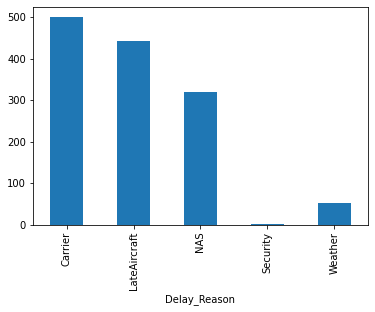

In [280]:
delayed_df = delayed_ca_flights.groupby(['Delay_Reason']).apply(len)
delayed_df.plot.bar()

Majority of the reason of delay here is due to Carrier

In [281]:
# In case of Early or Time Departures
ca_early_dept = delayed_ca_flights[delayed_ca_flights['departure_delay']==0]
ca_early_dept['Delay_Reason'].value_counts()

NAS             275
LateAircraft     12
Carrier          10
Weather           1
Name: Delay_Reason, dtype: int64

Here, Carrier is the least one affecting the delay instead NAS is the major reason here

<AxesSubplot:>

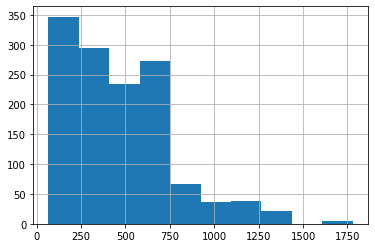

In [284]:
delayed_ca_flights['Flight_Distance'].hist(bins=10)

Large Distance doesn't really play a major role in Flight delay

In [307]:
dest_df = pd.DataFrame(delayed_ca_flights.groupby(['Destination_Airport']).apply(len))
dest_df.reset_index(inplace=True)
dest_df.columns = ['Destination_Airport', 'value']
dest_df_filter = dest_df[dest_df['value']>=30].sort_values(by='value')

<AxesSubplot:xlabel='Destination_Airport'>

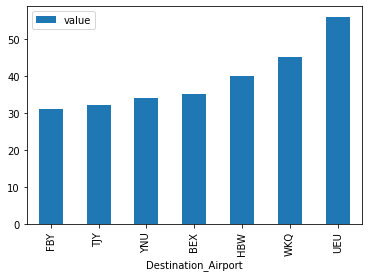

In [308]:
dest_df_filter.plot.bar(x='Destination_Airport')

Destination Airports where flights are majorly delayed

#### More Analysis could be done around Departure/Arrival Taxi and Wheel off and their impact on Flight delay